In [1]:
# import all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import queue
from collections import Counter

In [2]:
class Gameboard:
    def __init__(self, shape):
        self.nrows, self.ncols = shape, shape
        self.col_labels, self.row_labels = [i for i in range(shape)], [i for i in range(shape)]
        # create board matrix
        self.board = self.fast_random_bool([self.nrows, self.ncols])

        # create figure and axes
        self.fig, self.ax = plt.subplots()

        # show all ticks
        self.ax.set_xticks(np.arange(self.ncols))
        self.ax.set_yticks(np.arange(self.nrows))

        # set custom labels
        self.ax.set_xticklabels(self.col_labels)
        self.ax.set_yticklabels(self.row_labels)
        
        # set up minor ticks
        self.ax.minorticks_on()
        self.ax.set_xticks(np.arange(self.ncols) + 0.5, minor=True)
        self.ax.set_yticks(np.arange(self.nrows) + 0.5, minor=True)

        # turn off the display of all ticks
        self.ax.tick_params(which='both', top=False, left=False, right=False, bottom=False)

        # show grid on minor ticks
        self.ax.grid(which='minor', linestyle='-', color='black')

        # set bounds
        self.ax.set_xbound(-0.5, 9.5)
        self.ax.set_ybound(-0.5, 9.5)
        
        # initialize counter
        self.bulb_count = np.sum(self.board)
    
    # method from stackoverflow
    def fast_random_bool(self, shape):
        n = np.prod(shape)
        nb = -(-n // 8)  # ceiling division
        b = np.frombuffer(np.random.bytes(nb), np.uint8, nb)
        return np.unpackbits(b)[:n].reshape(shape).view(np.bool)

    # triggers a single bulb
    def trigger_bulb(self, x, y):
        self.board[y, x] = not self.board[y, x]

    # makes a single move which triggers multiple bulbs
    def play(self, x, y):
        self.trigger_bulb(x, y)
        for loc in self.neighbours(x, y):
            self.trigger_bulb(loc[0], loc[1])
        self.bulb_count = np.sum(self.board)

    # takes an array of moves and plays them
    def play_multiple(self, array):
        for move in array:
            self.play(move[0], move[1])

    # restarts game
    def restart(self):
        self.board = self.fast_random_bool([self.nrows, self.ncols])
        self.bulb_count = np.sum(self.board)

    def set_state(self, matrix):
        self.board = np.flip(matrix, 0)
        self.bulb_count = np.sum(self.board)
        
    def get_state(self):
        return self.board
        
    # returns array of neighbouring locations of passed location (diagonal direction doesn't count)
    def neighbours(self, x, y):
        result = []

        if self.in_range(x, y - 1):
            result.append((x, y - 1))

        if self.in_range(x, y + 1):
            result.append((x, y + 1))

        if self.in_range(x - 1, y):
            result.append((x - 1, y))

        if self.in_range(x + 1, y):
            result.append((x + 1, y))

        return result
    
    # returns True if passed location is within bounds
    def in_range(self, x, y):
        if y >= 0 and y < self.nrows and x >= 0 and x < self.ncols:
            return True
        return False
        
    # returns True if all bulbs are on
    def is_game_over(self):
        if self.bulb_count == self.nrows * self.ncols:
            return True
        return False
    
    # returns number of bulbs currently on
    def get_bulb_count(self):
        return self.bulb_count
    
    # returns matplotlib figure
    def get_figure(self, figsize=None):
        self.update()
        if figsize is not None:
            self.fig.set_size_inches(figsize, figsize)
        return self.fig
    
    # returns matplotlib axes
    def get_axes(self):
        self.update()
        return self.ax
    
    # applies changes made to board
    def update(self):
        self.ax.imshow(self.board, origin='lower', vmin=0, vmax=1)

    # make a queue and do bfs for solution (this guarantees the least amount of moves but takes a long time)
    def solve_bfs(self):
        # method number 1
        q = queue.Queue()

        visited = set()
        visited.add(tuple(board.get_state().flat))
        for i in range(self.nrows):
            for j in range(self.ncols):
                # put the first elements in queue
                q.put([(i, j)])

        while True:
            # make a recorded set of moves
            moves = q.get()
            if q.empty():
                # print("answer not found")
                return None
            board.play_multiple(moves)
            # check for win
            if board.is_game_over():
                board.play_multiple(moves)
                # print("answer: ", moves)
                return moves
            # enqueue a new set of moves if this state hasn't been visited yet
            if tuple(board.get_state().flat) not in visited:
                for i in range(self.nrows):
                    for j in range(self.ncols):
                        q.put(moves + [(i, j)])
            # add the current move to the visited set
            visited.add(tuple(board.get_state().flat))
            # revert play
            board.play_multiple(moves)

        #def solve_elim(self):

In [3]:
%%capture
board = Gameboard(2)

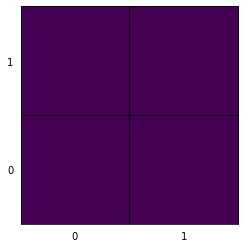

In [4]:
board.get_figure()

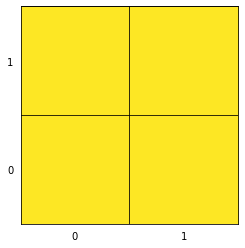

In [5]:
answer = board.solve_bfs()
board.play_multiple(answer)
board.get_figure()

In [6]:
# plots the lengths of the moves from the array of moves
def plot_length_dist(moves):
  lengths = []
  for move in moves:
      if move is None:
          lengths.append(0)
      else:
          lengths.append(len(move))
  plt.hist(lengths, np.arange(-0.5, np.max(lengths) + 2, 1), edgecolor='black')
  plt.show()

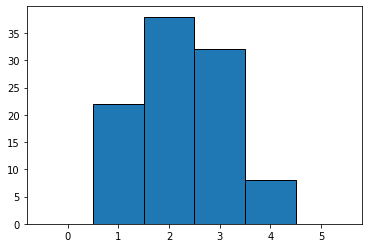

In [7]:
moves = []
for _ in range(100):
    board.restart()
    moves.append(board.solve_bfs())
plot_length_dist(moves)

In [8]:
# board.set_state(np.array([[False, True, False],
#                           [True, False, True],
#                           [False, False, False]]))

In [9]:
# for 2x2 matrix the equation is:
# b1 + x1 + x2 + x3 = 1
# b2 + x1 + x2 + x4 = 1
# b3 + x1 + x3 + x4 = 1
# b4 + x2 + x3 + x4 = 1
# [1 1 1 0]
# [1 1 0 1]
# [1 0 1 1]
# [0 1 1 1]
# *
# [x1 x2 x3 x4]
# =
# [1-b1 1-b2 1-b3 1-b4]

In [10]:
def get_moves_matrix(shape):
    mat = np.zeros((shape[0]**2, shape[1]**2))
    for i in range(shape[0]):
        for j in range(shape[1]):
            for n in board.neighbours(i, j) + [(i, j)]:
                mat[i * shape[0] + j, n[0] * shape[0] + n[1]] += 1
    return mat

def get_diff_matrix(shape):
    mat = np.ones(np.prod(shape))
    for i in range(shape[0]):
        for j in range(shape[1]):
            mat[i * shape[0] + j] -= board.get_state()[i, j]
    return mat

def get_linalg_moves(x):
    moves = []
    for i in range(len(x)):
        if x[i] == 1:
            moves.append((i % int(np.sqrt(len(x))), i // int(np.sqrt(len(x)))))
    return moves

In [11]:
%%capture
board = Gameboard(3)

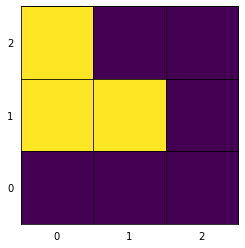

In [12]:
board.get_figure()

In [13]:
board.restart()
a = get_moves_matrix((3, 3))
b = get_diff_matrix((3, 3))
x = np.rint(np.linalg.solve(a, b) * np.linalg.det(a)).astype('int') % 2
get_linalg_moves(x)

[(0, 0), (1, 0), (1, 1), (2, 1), (1, 2), (2, 2)]

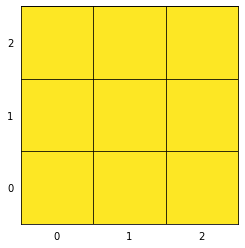

In [14]:
board.play_multiple(get_linalg_moves(x))
board.get_figure()

In [15]:
def rref(A, B=None):
    i, piv = 0, 0
    while i + piv < len(A):
        if A[i, i + piv] == 1:
            for k in range(len(A)):
                if k == i:
                    continue
                if A[k, i + piv] == 1:
                    A[k, :] += A[i, :]
                    A[k, :] %= 2
                    if B is not None:
                        B[k] = (B[k] + B[i]) % 2
        else:
            row_changed = False
            for k in range(len(A) - i - 1):
                if A[i + k + 1, i + piv] == 1:
                    temp = A[i, :].copy()
                    A[i, :] = A[i + k + 1, :]
                    A[i + k + 1, :] = temp
                    if B is not None:
                        temp = B[i]
                        B[i] = B[i + k + 1]
                        B[i + k + 1] = temp
                    row_changed = True
                    break
            if not row_changed:
                piv += 1
            i -= 1
        i += 1

In [16]:
# A, B must be in rref, must be used only when unique solution exists
def exact(A, B):
    result = [0] * len(A)
    for row_index in range(len(A)):
        one_index = np.where(A[row_index] == 1)[0][0]
        result[one_index] = B[row_index]
    return result

In [17]:
def null_space(A):
    results = []
    i, piv, col = 0, 0, 0
    to_fix = []
    while col < len(A):
        if A[i, i + piv] == 1:
            i += 1
        else:
            to_fix.append(col)
            piv += 1
        col += 1
    no_fix = np.delete(np.arange(0, len(A), 1), to_fix)
    for col_num in range(len(to_fix)):
        result = np.array([0] * len(A))
        fixed = to_fix[col_num]
        result[fixed] = 1
        for i in range(len(A)):
            if A[i, fixed] == 1:
                result[no_fix[i]] = (result[no_fix[i]] + 1) % 2
        results.append(result)
    return results

In [18]:
def particular(A, B):
    i, piv, col = 0, 0, 0
    to_fix = []
    while col < len(A):
        if A[i, i + piv] == 1:
            i += 1
        else:
            to_fix.append(col)
            piv += 1
        col += 1
    no_fix = np.delete(np.arange(0, len(A), 1), to_fix)
    
    if 1 in B[-len(to_fix):]:
        #print('no solution, sorry')
        return None

    result = [0] * len(A)
    for i in range(len(no_fix)):
        result[no_fix[i]] = B[i]
    fixed = to_fix[0]
    result[fixed] = 1
    for i in range(len(A)):
        if A[i, fixed] == 1:
            result[no_fix[i]] = (result[no_fix[i]] + 1) % 2
    return result

In [19]:
def powerset(seq):
    if len(seq) <= 1:
        yield seq
        yield []
    else:
        for item in powerset(seq[1:]):
            yield [seq[0]] + item
            yield item

In [20]:
# can solve for any board size, returns array of moves
def solve_linalg(A, B):
    rref(A, B)
    null = null_space(A)
    if null == []:
        return [get_linalg_moves(exact(A, B))]
    x = particular(A, B)
    if x is None:
        return None
    else:
        sols = [(sum(s) + x) % 2 for s in powerset(null) if s != []]
        sols += [x]
    return [get_linalg_moves(sol) for sol in sols]

In [21]:
%%capture
board = Gameboard(5)

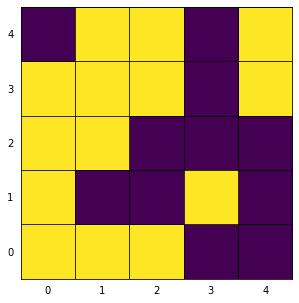

In [22]:
board.restart()
board.get_figure(5)

In [23]:
%%time
A = get_moves_matrix((5, 5))
B = get_diff_matrix((5, 5))
sol = solve_linalg(A, B)

CPU times: user 4.07 ms, sys: 6 µs, total: 4.08 ms
Wall time: 4.14 ms


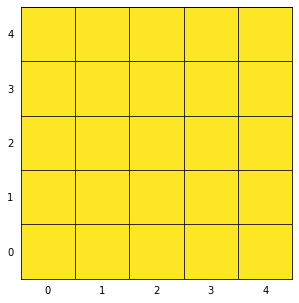

In [24]:
board.play_multiple(sol[0])
board.get_figure()

In [25]:
board.play_multiple(sol[0])
for s in sol:
    board.play_multiple(s)
    if board.is_game_over():
        print("solved")
    board.play_multiple(s)

solved
solved
solved
solved


In [26]:
# let's find out what board sizes are solvable
%%capture
solvable = {}
for size in range(2, 101):
    board = Gameboard(size)
    a = get_moves_matrix((size, size))
    solvable[size] = np.linalg.det(a) != 0

In [27]:
for size in solvable:
    if not solvable[size]:
        print(str(size) + "x" + str(size) + " not always solvable")

4x4 not always solvable
5x5 not always solvable


In [28]:
def rref_general(A, B):
    i, piv = 0, 0
    while i + piv < len(A):
        if A[i, i + piv] == 1:
            for k in range(len(A)):
                if k == i:
                    continue
                if A[k, i + piv] == 1:
                    A[k, :] += A[i, :]
                    A[k, :] %= 2
                    B[k] = B[k] + B[i]
        else:
            row_changed = False
            for k in range(len(A) - i - 1):
                if A[i + k + 1, i + piv] == 1:
                    temp = A[i, :].copy()
                    A[i, :] = A[i + k + 1, :]
                    A[i + k + 1, :] = temp
                    temp = B[i]
                    B[i] = B[i + k + 1]
                    B[i + k + 1] = temp
                    row_changed = True
                    break
            if not row_changed:
                piv += 1
            i -= 1
        i += 1

In [29]:
# find out when is the random 5x5 board solvable

In [30]:
%%capture
board = Gameboard(5)

In [31]:
B_general = []
for i in range(25):
    B_general.append([i])
print(B_general)
board.restart()
A = get_moves_matrix((5, 5))
rref_general(A, B_general)

[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24]]


In [32]:
promises = []
for i in range(2):
    counter = Counter(B_general[-1 - i])
    promise = [0] * 25
    for c in counter:
        promise[c] = (counter[c] % 2)
    promises.append(promise)
promises

[[1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1],
 [0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0]]

In [33]:
correct_guess = 0
for i in range(1000):
    board.restart()
    state = board.get_state()
    state_flat = state.flatten()
    promises_kept = 0
    solved_guess = False
    for promise in promises:
        p_sum = 0
        for i in range(len(state_flat)):
            if state_flat[i] and promise[i] == 1:
                p_sum += 1
        if p_sum % 2 == 0 and sum(promise) % 2 == 0:
            promises_kept += 1
        if p_sum % 2 == 1 and sum(promise) % 2 == 1:
            promises_kept += 1
    if promises_kept == 2:
        solved_guess = True
    A = get_moves_matrix((5, 5))
    B = get_diff_matrix((5, 5))
    rref(A, B)
    solved_real = particular(A, B) is not None
    if (solved_real and not solved_guess) or (not solved_real and solved_guess):
        print("oops")
    else:
        correct_guess += 1
print('correct guesses: {}/1000'.format(str(correct_guess)))

correct guesses: 1000/1000


In [34]:
# do the same for 4x4 board
%%capture
board = Gameboard(4)

In [35]:
B_general = []
for i in range(16):
    B_general.append([i])
board.restart()
A = get_moves_matrix((4, 4))
rref_general(A, B_general)
promises = []

for i in range(4):
    counter = Counter(B_general[-1 - i])
    promise = [0] * 16
    for c in counter:
        promise[c] = (counter[c] % 2)
    promises.append(promise)
print(promises)

correct_guess = 0
for i in range(1000):
    board.restart()
    state = board.get_state()
    state_flat = state.flatten()
    promises_kept = 0
    solved_guess = False
    for promise in promises:
        p_sum = 0
        for i in range(len(state_flat)):
            if state_flat[i] and promise[i] == 1:
                p_sum += 1
        if p_sum % 2 == 0 and sum(promise) % 2 == 0:
            promises_kept += 1
        if p_sum % 2 == 1 and sum(promise) % 2 == 1:
            promises_kept += 1
    if promises_kept == 4:
        solved_guess = True
    A = get_moves_matrix((4, 4))
    B = get_diff_matrix((4, 4))
    rref(A, B)
    solved_real = particular(A, B) is not None
    if (solved_real and not solved_guess) or (not solved_real and solved_guess):
        print("oops")
    else:
        correct_guess += 1
print('correct guesses: {}/1000'.format(str(correct_guess)))

[[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1], [1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0], [1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0], [0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0]]
correct guesses: 1000/1000
